From the last [blog post](https://wckdouglas.github.io/2020/07/experiment-with-jax), I experimented with [JAX](https://github.com/google/jax). And this time, I'll experiment a probablistic programming package [NumPyro](http://num.pyro.ai/en/latest/getting_started.html) which used JAX as it's backend.

So what is probablistic programming? Quoting from Wikipedia:

> Probabilistic programming (PP) is a programming paradigm in which probabilistic models are specified and inference for these models is performed automatically.

Useful things that every probablistic programming frameworks do are variational inference (fitting parameters for models), or posterior sampling, etc. 

Here's a [good introduction](https://ericmjl.github.io/bayesian-deep-learning-demystified/#/IntroductionSlide) on how probablistic programming relates to deep learning.

In python, the most popular probablistic framework is probably [pymc3](https://docs.pymc.io/en/v3/), It uses [Theano](https://github.com/Theano/Theano) as the backend, which is not in active development anymore (with a new fork called [Aesara](https://aesara.readthedocs.io/en/latest/)). Apart from pymc3, there are multiple other packages that do similar things, such as [pymc4](https://github.com/pymc-devs/pymc4) (built on [tensorflow-probability](https://www.tensorflow.org/probability), and is in a early phase of development), [PyStan](https://pystan.readthedocs.io/en/latest/) (which requires writing non-python code to define the model), [pyro](https://pyro.ai/) (an open source project from Uber, using Facebook's [pytorch](https://pytorch.org/) as backend). And recently, Uber is rewriting pyro using NumPy/JAX backend to [speed up](https://pyro.ai/) sampling:

> NumPyro Release We’re excited to announce the release of NumPyro, a NumPy-backed Pyro using JAX for automatic differentiation and JIT compilation, with over 100x speedup for HMC and NUTS! See the examples and documentation for more details.

In [48]:
import warnings
warnings.filterwarnings('ignore')
import arviz as az
import jax
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive
from jax import random
from numpyro.diagnostics import hpdi
from numpyro.infer import MCMC, NUTS
numpyro.set_host_device_count(4)

## Hypothesis testing examples ##


Say we spend a few days counting whales and sharks in the Atlantic and
Indian oceans. In the Atlantic ocean we find 8 whales and 1 shark, in the
Indian ocean 2 whales and 5 sharks. Then our contingency table is::

            Atlantic  Indian
    whales     8        2
    sharks     1        5

We use this table to find the p-value:

```
>>> from scipy.stats import fisher_exact
>>> oddsratio, pvalue = fisher_exact([[8, 2], [1, 5]])
>>> pvalue
0.0349...
```

The probability that we would observe this or an even more imbalanced ratio
by chance is about 3.5%.  A commonly used significance level is 5%--if we
adopt that, we can therefore conclude that our observed imbalance is
statistically significant; whales prefer the Atlantic while sharks prefer
the Indian ocean.


There are different mis-interpretations of p-value, such as on [the definition itself](https://www.nature.com/articles/nmeth.4210.pdf) and the [meaning of magnitude of a p value](https://www.cell.com/action/showPdf?pii=S2405-4712%2819%2930071-7)

In [49]:
def model(x1, x2, y1, y2, n_observed=1000):
    prior1 = numpyro.sample("prior1", dist.Beta(x1,x2))
    prior2 = numpyro.sample("prior2", dist.Beta(y1,y2))
    out1 = numpyro.sample("out1", dist.Binomial(total_count=n_observed, probs=prior1))
    out2 = numpyro.sample("out2", dist.Binomial(total_count=n_observed, probs=prior2))
    diff = numpyro.deterministic("diff", out1-out2)

In [50]:
whales_in_atlantic_ocean = 8
sharks_in_atlantic_ocean = 1
whales_in_indian_ocean = 2
sharks_in_indian_ocean = 5
n_observed = 1000
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=100, num_chains=4)
rng_key = random.PRNGKey(0)
mcmc.run(
    rng_key, 
    x1=whales_in_atlantic_ocean, 
    x2=sharks_in_atlantic_ocean,
    y1=whales_in_indian_ocean, 
    y2=sharks_in_indian_ocean,
    n_observed=n_observed
)

sample: 100%|██████████| 600/600 [00:00<00:00, 1122.81it/s, 3 steps of size 7.07e-01. acc. prob=0.93] 


(array([ 5.,  5.,  5.,  7.,  9., 23., 16., 18.,  8.,  4.]),
 array([159. , 238.6, 318.2, 397.8, 477.4, 557. , 636.6, 716.2, 795.8,
        875.4, 955. ]),
 <BarContainer object of 10 artists>)

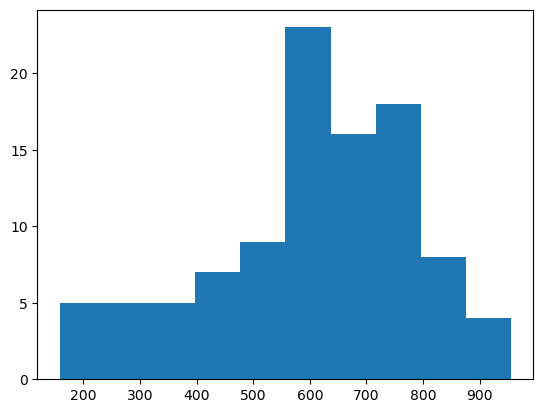

In [51]:
preditive = Predictive(model, num_samples=100)
pred = preditive(
    rng_key,
    x1=whales_in_atlantic_ocean, 
    x2=sharks_in_atlantic_ocean,
    y1=whales_in_indian_ocean, 
    y2=sharks_in_indian_ocean,
    n_observed=n_observed
)
diff = pred['diff']
plt.hist(diff)

In [52]:
mcmc.print_summary()# exclude_deterministic=False)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    prior1      0.88      0.10      0.90      0.74      1.00    337.29      1.01
    prior2      0.28      0.15      0.27      0.03      0.51    282.16      1.00

Number of divergences: 0


In [53]:
interval = 0.95
lower_bound, upper_bound = hpdi(diff, prob=interval)
print(f"There's a {interval*100}% chance there are"\
      f" {100*lower_bound/n_observed}-{100*upper_bound/n_observed}% more whales in Atlantic oceans" )

There's a 95.0% chance there are 21.9-90.4% more whales in Atlantic oceans


## Regression ##

In [54]:
sample_size = 100
x = np.random.random_sample(sample_size) * 10
intercept = np.random.random(1)[0] * 10
beta = np.random.random_integers(1)
noise = np.random.normal(loc=0,scale=1, size=sample_size)
y = beta * x + intercept + noise
print(f"Simulated beta: {beta}, intercept: {intercept:0.2}")

Simulated beta: 1, intercept: 1.4


In [55]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x.reshape(-1,1),y)

LinearRegression()

In [56]:
print(f"sklearn fitting beta={lr.coef_[0]:.2}, intercept = {lr.intercept_:.2}")

sklearn fitting beta=1.1, intercept = 1.0


In [57]:
def numpyro_linear_model(x, y):
    beta = numpyro.sample("beta", dist.Normal(0,1))
    intercept = numpyro.sample("intercept", dist.Normal(0,1))
    error = numpyro.sample("error", dist.Exponential(0.1))
    pred = beta*x + intercept
    numpyro.sample("pred", dist.Normal(pred, error), obs=y)

In [62]:
nuts_kernel = NUTS(numpyro_linear_model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=200, num_chains=4)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, x, y)
print(f"NumPyro fitting beta={mcmc.get_samples()['beta'][0]:.2}, intercept = {mcmc.get_samples()['intercept'][0]:.2}")

sample: 100%|██████████| 700/700 [00:00<00:00, 941.82it/s, 7 steps of size 4.03e-01. acc. prob=0.91] 


NumPyro fitting beta=1.1, intercept = 0.89


Text(0, 0.5, 'y')

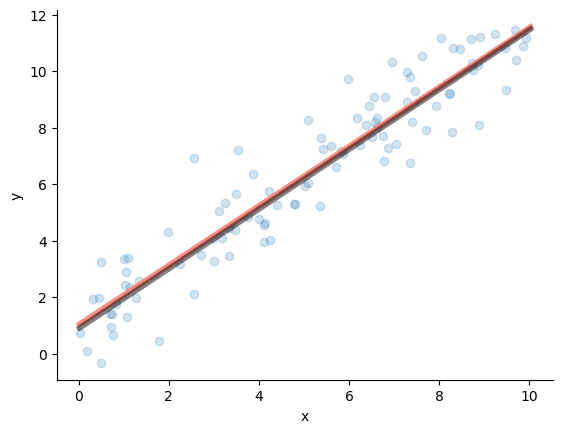

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x,y, label='raw data', alpha=0.2)
xrange = np.arange(x.min(), x.max()+1)
ax.plot(xrange, lr.coef_[0] * xrange + lr.intercept_, 
        color='salmon', label='sklearn',lw=4, 
       alpha=0.9)
ax.plot(xrange, 
        mcmc.get_samples()['beta'][0] * xrange + mcmc.get_samples()['intercept'][0],
       color='black', label='numpyro',
       lw=4, alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('x')
ax.set_ylabel('y')